# **OCR Detection**

In [ ]:
import os
import io
import cv2
import zipfile
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

## Segmenting into numbers and symbols:

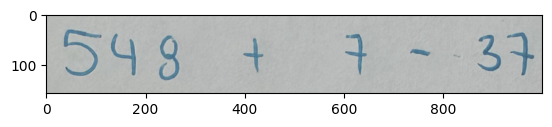

In [ ]:
def format(img):
  #resizing so width = 1000, while maintaining aspect ratio
  h, w, c = img.shape
  if (w>1000):
    aspect_ratio = w/h
    w = 1000
    h = int(w/aspect_ratio)
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)

  plt.imshow(img) # show image
  plt.show()
  return img

img = cv2.imread('equation.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image colours open cv format (RGB)
img = format(img)

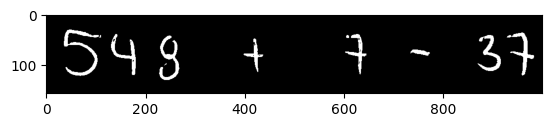

In [ ]:
def thresholding(img):
  grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # contrast: pixel intensity > 80 threshold = 255 (max value)
  # inverting: THRESH_BINARY_INV = max values --> 0, all other values --> 255
  ret, thresh = cv2.threshold(grey_img,130,255,cv2.THRESH_BINARY_INV) #high contrast, then inverting image
  plt.imshow(thresh, cmap='gray')
  return thresh

thresh_img = thresholding(img)

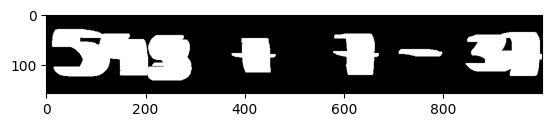

In [ ]:
# detecting lines
kernel = np.ones((3,50), np.uint8) # kernel of size 3x85 to detect high intensity of surrounding pixels around selected pixel (blank space)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)  # finds regions of low intensity & sets all pixels in kernel to low intensity (boxy regions)
plt.imshow(dilated, cmap='gray')

In [ ]:
# detects contours
# RETR_EXTERNAL: contour retrieval method (finds outermost contours)
# HAIN_APPROX_NONE: contour approximation method (all points = used for exact shape rather than approximation of shape)
(contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_nums = sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0]) # array of contour lines sorted lowest to highest y-value (top->bottom)

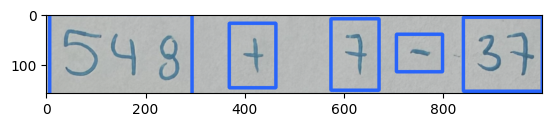

In [ ]:
img2 = img.copy()
terms = []

# uses coordinates in contour_lines to draw bounding rectangles
for ctr in contour_nums:
  x, y, w, h = cv2.boundingRect(ctr)
  cv2.rectangle(img2, (x-5, y-30), (x+w, y+h+30), (40, 100, 250), 5) # (image,top-left corner, bottom-right corner, blue, thickness)
  terms.append([x-5, y-30, x+w, y+h+30])

plt.imshow(img2)

In [ ]:
elements = 5
print('Noise:', len(terms)!=elements) # ensuring no overlapping contours/noise

Noise: False


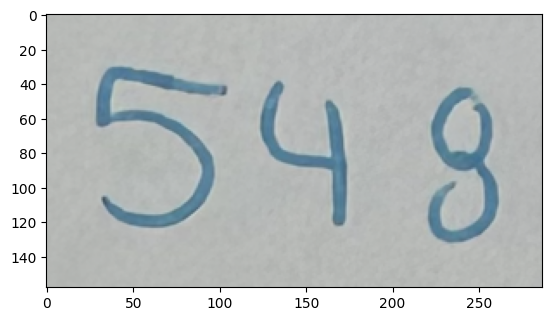

In [ ]:
first_term = terms[0]
# [0] = xmin, [1] = ymin, [2] = xmax, [3] = ymax
first_term_roi = img[first_term[1]:first_term[3], first_term[0]:first_term[2]]
img2 = format(first_term_roi)

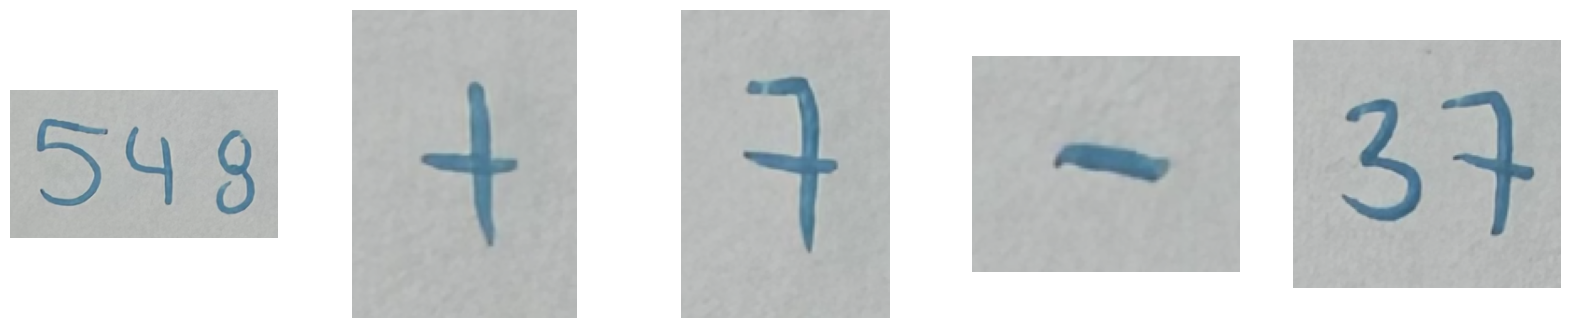

In [ ]:
# grid
num_cols = len(terms)
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

term_roi = []
for i in range(len(terms)):
    image = img[terms[i][1]:terms[i][3], terms[i][0]:terms[i][2]]
    term_roi.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

## Segmenting  numbers into digits:

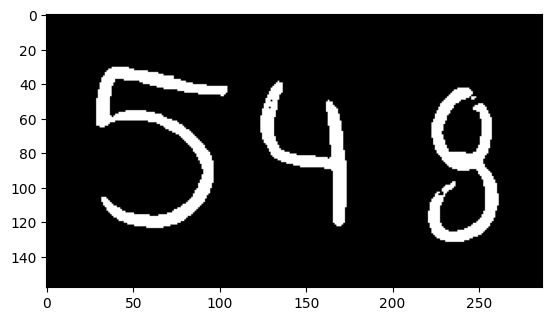

In [ ]:
def thresholding_digit(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    return thresh

term_thresh = []
for i in range(len(term_roi)):
  term_thresh.append(thresholding_digit(term_roi[i]))

plt.imshow(term_thresh[0], cmap='gray')

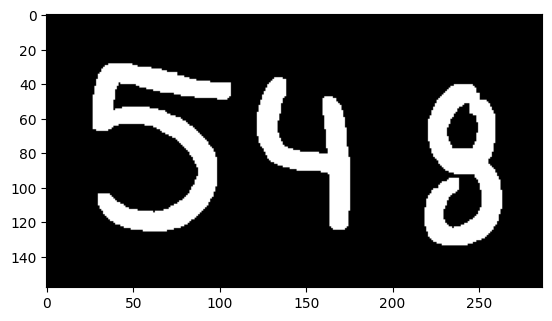

In [ ]:
#dilation
kernel = np.ones((5,5), np.uint8)
term_dilated = []
for i in range(len(term_thresh)):
  term_dilated.append(cv2.dilate(term_thresh[i], kernel, iterations = 1))

plt.imshow(term_dilated[0], cmap='gray')

In [ ]:
digits = []
outlined_digits = []
unoutlined_digits = []

for i in range(len(term_dilated)):
  image = term_roi[i]
  unoutlined_digits.append(image.copy())
  digs = []
  for num in contour_nums:
    # roi of each line
    x3, y3, w3, h3 = cv2.boundingRect(num)
    roi_dig = term_dilated[i][y3:y3+w3, x3:x3+w3]

    # draw contours on each num
    (cnt2, heirarchy2) = cv2.findContours(roi_dig.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_digs = sorted(cnt2, key=lambda cntr : cv2.boundingRect(cntr)[0])

    for contour in contour_digs:

      if cv2.contourArea(contour) < 400:
          continue

      x4, y4, w4, h4 = cv2.boundingRect(contour)
      digs.append([x3+x4, y3+y4, x3+x4+w4, y3+y4+h4])
      cv2.rectangle(image, (x3+x4, y3+y4), (x3+x4+w4, y3+y4+h4), (255,255,100),2)
  outlined_digits.append(image)
  digits.append(digs)

array([[[186, 188, 187],
        [188, 190, 189],
        [188, 190, 189],
        ...,
        [178, 180, 179],
        [181, 183, 182],
        [180, 182, 182]],

       [[186, 189, 188],
        [187, 189, 188],
        [186, 188, 187],
        ...,
        [178, 180, 180],
        [182, 184, 183],
        [179, 181, 180]],

       [[186, 188, 188],
        [184, 186, 186],
        [184, 186, 185],
        ...,
        [179, 181, 181],
        [180, 182, 181],
        [176, 179, 178]],

       ...,

       [[182, 185, 184],
        [181, 183, 182],
        [180, 182, 181],
        ...,
        [181, 183, 182],
        [181, 183, 183],
        [184, 186, 185]],

       [[181, 183, 182],
        [181, 183, 182],
        [183, 185, 184],
        ...,
        [179, 181, 181],
        [179, 181, 180],
        [179, 181, 180]],

       [[182, 185, 184],
        [183, 185, 184],
        [183, 186, 185],
        ...,
        [179, 181, 180],
        [179, 181, 180],
        [178, 180, 179]]], dtype=uint8)
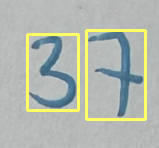

In [ ]:
outlined_digits[4]

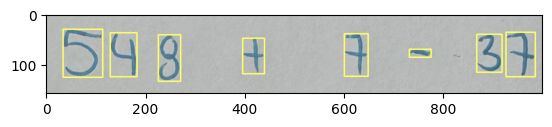

In [ ]:
plt.imshow(img)

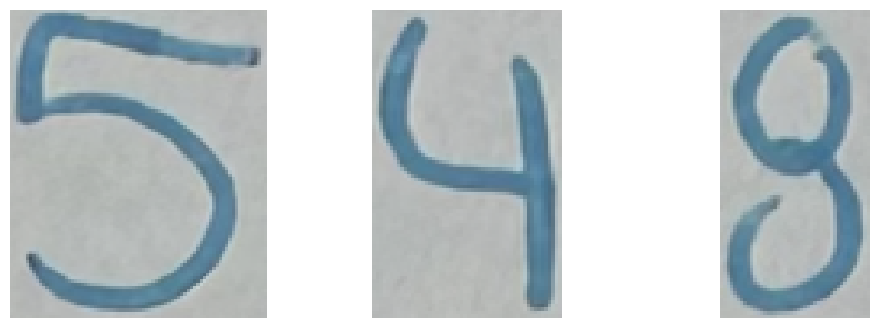

In [ ]:
# grid
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Change num_cols to 3

for i in range(len(digits[0])):
    roi = digits[0][i]
    img_display = unoutlined_digits[0]
    roi_display = img_display[roi[1]:roi[3], roi[0]:roi[2]]
    axes[i].imshow(roi_display)
    axes[i].axis('off')

for j in range(0, len(axes)):
    axes[j].axis('off')

plt.show()

## Digit detection neural network:

In [ ]:
import tensorflow as tf
import numpy as np
import zipfile
import os
from PIL import Image

# Define function to extract images from the zip file
def extract_images(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            # Skip extraction of directories and files starting with '__MACOSX'
            if not file_info.filename.startswith('__MACOSX'):
                zip_ref.extract(file_info, extract_to)

# Extract images from the zip file, skipping '__MACOSX' directory
extract_images('symbols.zip', 'symbols')

# Define function to load images and labels from directory
def load_data(directory):
    images = []
    labels = []
    label_mapping = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
                     'slash': 10, 'minus': 11, 'dot': 12, 'plus': 13, 'w': 14, 'x': 15, 'y': 16, 'z': 17}
    for root, dirs, files in os.walk(directory):
        for image_file in files:
            if not image_file.startswith('__MACOSX') and not image_file.startswith('._'):
                image_path = os.path.join(root, image_file)
                # Attempt to open the image file
                try:
                    img = Image.open(image_path).convert('L')  # Convert to grayscale
                    img = img.resize((28, 28))
                    img = np.array(img) / 255.0  # Normalize
                    images.append(img)
                    # Extract label from the filename
                    label_str = image_file.split('-')[0]  # Get the label part from the filename
                    label = label_mapping.get(label_str, None)  # Map labels to IDs
                    if label is not None:
                        labels.append(label)
                    else:
                        print(f"Skipping image file '{image_path}' due to invalid label: {label_str}")
                except Exception as e:
                    print(f"Error loading image file '{image_path}': {e}")
    return np.array(images), np.array(labels)

# Load data
x_train, y_train = load_data('symbols')

# Shuffle the data if needed
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Split data into training and testing sets
split_ratio = 0.8  # 80% training, 20% testing
split_index = int(len(x_train) * split_ratio)
x_train, x_test = x_train[:split_index], x_train[split_index:]
y_train, y_test = y_train[:split_index], y_train[split_index:]

# Define and compile your model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)), # input layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(128, activation='relu'), # hidden layer
    tf.keras.layers.Dense(18, activation='softmax') # output layer (18 classes, including letters and symbols)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3)

# Save the model
model.save('handwritten_model')

# Load the model
loaded_model = tf.keras.models.load_model('handwritten_model')

# Evaluate the model
loss, accuracy = loaded_model.evaluate(x_test, y_test)
print("Test Loss:", round(loss, 2))
print("Test Accuracy:", round(accuracy, 2))


Epoch 1/3
675/675 [==============================] - 4s 5ms/step - loss: 0.9577 - accuracy: 0.7209
Epoch 2/3
675/675 [==============================] - 3s 4ms/step - loss: 0.4724 - accuracy: 0.8618
Epoch 3/3
169/169 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8822
Test Loss: 0.42
Test Accuracy: 0.88


In [ ]:
def convert(num):
  if np.all(num == 10):
      return 'slash'
  elif np.all(num == 11):
      return 'minus'
  elif np.all(num == 12):
      return 'dot'
  elif np.all(num == 13):
      return 'plus'
  elif np.all(num == 14):
      return '4'
  elif np.all(num == 15):
      return 'plus'
  elif np.all(num == 16):
      return '8'
  elif np.all(num == 17):
      return 'z'
  else:
      return str(num)

slash
1/1 [==============================] - 0s 63ms/step
Predicted Digit: slash


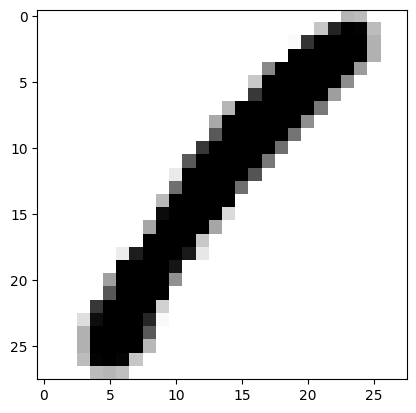

In [ ]:
plt.imshow(x_test[451], cmap='gray')
print(convert(y_test[451]))

prediction = model.predict(np.array([x_test[451]]))
print("Predicted Digit:", convert(np.argmax(prediction)))



In [ ]:
def resize_image(image):
  # resize, grayscale, contrast, invert
  h, w = image.shape[:2]
  new_height = int(min(28, h/w*40))
  image = cv2.resize(image, (28, new_height)) # 18
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return image


def adjust_img(image):

  # testing
  h, w = image.shape

  # Iterate through all pixels and adjust their intensity
  for y in range(h):
      for x in range(w):
          intensity = image[y, x]
          new_intensity = min(255, max(0, intensity * 0.05 - 6))
          image[y, x] = new_intensity

  # background
  background = np.ones((28, 28), dtype=np.uint8)
  background +=2

  y_offset = (28 - h) // 2
  x_offset = (28 - w) // 2
  background[y_offset:y_offset+h, x_offset:x_offset+w] = image


  return background


def img_to_int(img):
    img = resize_image(img)
    img = adjust_img(img)
    plt.imshow(img, cmap='gray')
    plt.show()

    # Prediction
    prediction = model.predict(np.array([img]))
    print("Predicted Digit:", convert(np.argmax(prediction)))
    return convert(np.argmax(prediction))


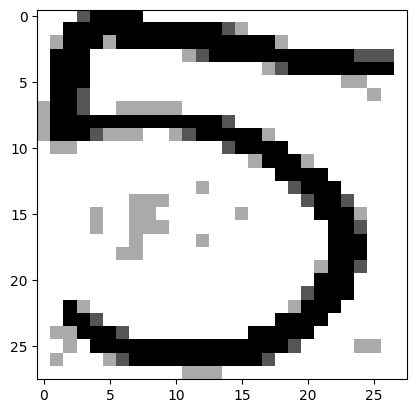

1/1 [==============================] - 0s 32ms/step
Predicted Digit: 5


'5'

In [ ]:
image = unoutlined_digits[0]
roi = digits[0][0]
image = image[roi[1]:roi[3], roi[0]:roi[2]]

img_to_int(image)

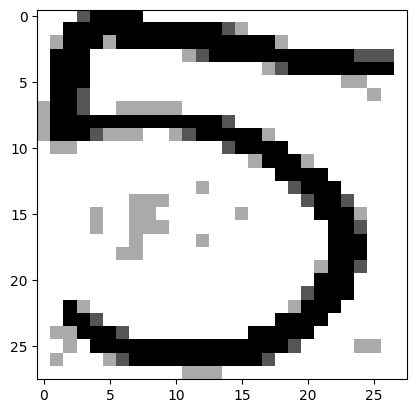

1/1 [==============================] - 0s 23ms/step
Predicted Digit: 5


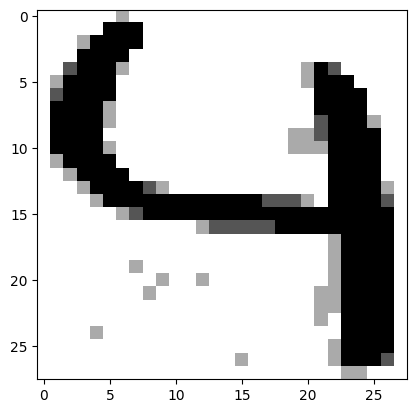

1/1 [==============================] - 0s 19ms/step
Predicted Digit: 4


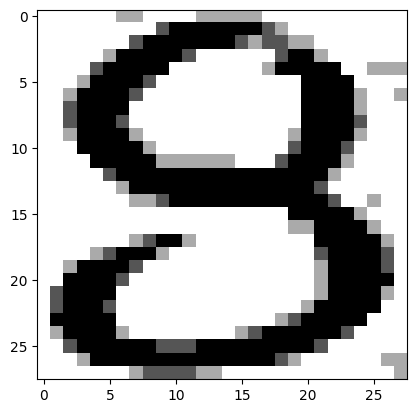

1/1 [==============================] - 0s 20ms/step
Predicted Digit: 8


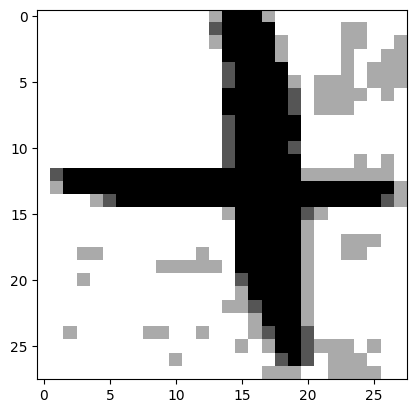

1/1 [==============================] - 0s 22ms/step
Predicted Digit: plus


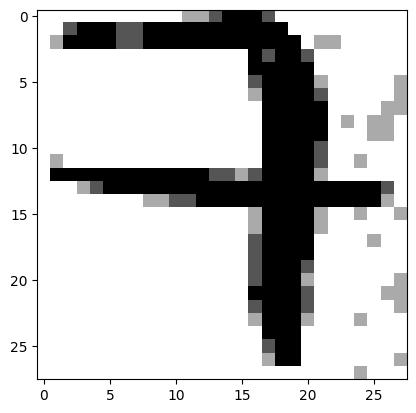

1/1 [==============================] - 0s 21ms/step
Predicted Digit: 3


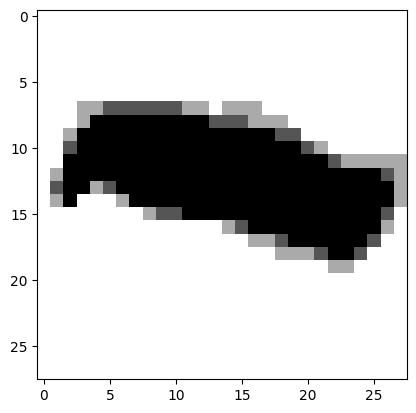

1/1 [==============================] - 0s 21ms/step
Predicted Digit: plus


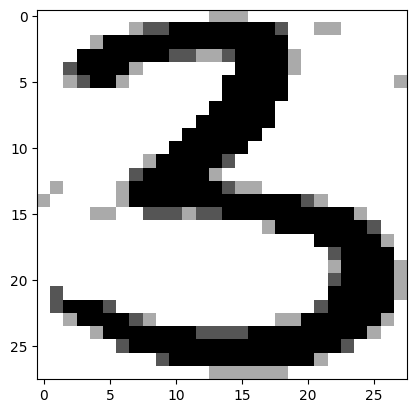

1/1 [==============================] - 0s 21ms/step
Predicted Digit: 3


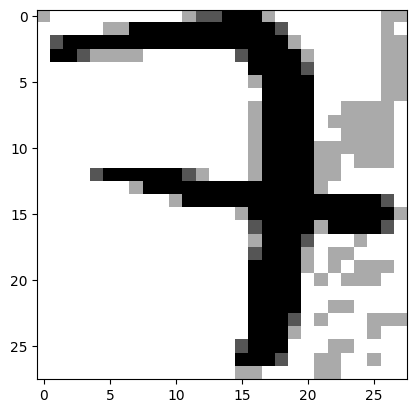

1/1 [==============================] - 0s 25ms/step
Predicted Digit: 3


In [ ]:
# answers = [5, 4, 8, 0, 7, 0, 3, 7]

counter = 0
accuracy = 0

term_pred = []
for i in range(len(digits)):
  digit_pred = []
  for j in range(len(digits[i])):
    roi = digits[i][j]
    img_display = unoutlined_digits[i]
    roi_display = img_display[roi[1]:roi[3], roi[0]:roi[2]]
    ans = img_to_int(roi_display)
    digit_pred.append(str(ans))

    # if counter != 3 and counter != 5 and ans == answers[counter]:
    #     accuracy+=1
    # counter+=1
  term_pred.append(digit_pred)

# print(round(accuracy /6*100,2))
# print('Accuracy: ', accuracy, '%')

## Transforming predictions into numbers:

548 + 3 + 33 
584


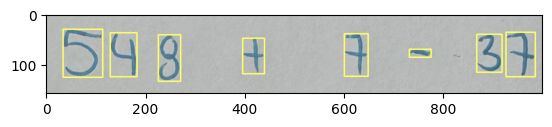

In [ ]:
equation = ''
for i in range(len(term_pred)):
  for j in range(len(term_pred[i])):
    if term_pred[i][j] == 'plus':
      equation += '+'
    elif term_pred[i][j] == 'minus':
      equation += '-'
    elif term_pred[i][j] == 'dot':
      equation += '-'
    elif term_pred[i][j] == 'slash':
      equation += '/'
    elif term_pred[i][j] == 'w':
      equation += 'w'
    elif term_pred[i][j] == 'x':
      equation += '+'
    elif term_pred[i][j] == 'y':
      equation += 'y'
    elif term_pred[i][j] == 'z':
      equation += 'z'
    else:
      equation += str(term_pred[i][j])
  equation += ' '

print(equation)
plt.imshow(img)
result = eval(equation)
